In [1]:
import sys
sys.path.insert(0, '../')
from util import util
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats.mstats import gmean
import seaborn as sns
import pandas as pd

Text(0.5,1,'Possible beta distributions')

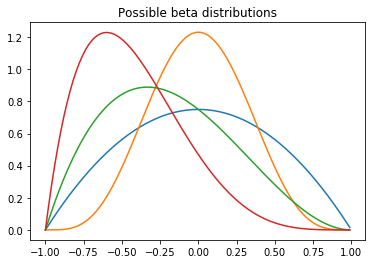

In [2]:
# plot the pdf within the range
x = np.arange (-1, 1, 0.01)

Y1 = st.beta(a = 2,b=2,loc=-1,scale=2)
z = Y1.pdf(x)
plt.plot(x,z)

Y2 = st.beta(a = 5,b=5,loc=-1,scale=2)
z = Y2.pdf(x)
plt.plot(x,z)

Y3 = st.beta(a = 2,b=3,loc=-1,scale=2)
z = Y3.pdf(x)
plt.plot(x,z)

Y4 = st.beta(a = 2,b=5,loc=-1,scale=2)
z = Y4.pdf(x)
plt.plot(x,z)
plt.title("Possible beta distributions")

In [3]:
def fit_beta(Y,n_samples,x_values,fit_type,plot_observed=False,**kwargs):
    #fig, axs = plt.subplots(4,5, figsize=(15, 15), facecolor='w', edgecolor='k')
    #fig.subplots_adjust(hspace = .5, wspace=.001)
    fig, axs = plt.subplots(2,5, figsize=(12, 8), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()
    for i in range(10):
        S = Y.rvs(n_samples)
        for ele in fit_type:
            if ele.lower() == 'mle':
                # fit a beta distribution using MLE
                a1, b1, loc1, scale1 = st.beta.fit(S,**kwargs)

                fitted_beta = st.beta(a = a1,b=b1,loc=loc1,scale=scale1)

                #plt.hist(S,normed=True)

                y_values = fitted_beta.pdf(x_values)
            elif ele.lower() == 'kde':
                # fit a kde, optimising bandwidth
                fitted = st.gaussian_kde(S,bw_method='scott')
                y_values = fitted.pdf(x_values)
            elif ele.lower() == 'mse':
                params = st.beta.fit(S,**kwargs)
                a1,b1,loc1,scale1 = minimize(maximum_spacing,params,args=(S)).x
                fitted_beta = st.beta(a=a1,b=b1,loc=loc1,scale=scale1)
                y_values = fitted_beta.pdf(x_values)
            elif ele.lower() == 'ks':
                params = st.beta.fit(S,**kwargs)
                a1,b1,loc1,scale1 = minimize(compute_kstest,params,args=(S)).x
                fitted_beta = st.beta(a=a1,b=b1,loc=loc1,scale=scale1)
                y_values = fitted_beta.pdf(x_values)
            else:
                raise ValueError("Not a valid estimation method")
            
            axs[i].plot(x_values, y_values,label=ele)
            
        if plot_observed:
            axs[i].hist(S,normed=True,label='Observed samples')
        axs[i].plot(x_values, Y.pdf(x_values),label='True pdf')
        axs[i].yaxis.set_visible(False)
    axs[i].legend()

In [4]:
def sampleSpacings(x):
    #calculates the sample spacings of X
    D=[xi-x[i] for i,xi in enumerate(x[1:])]
    return np.array(D)

def maximum_spacing(parameters,samples):
    # sort the samples
    orderedSample=np.sort(samples)
    
    # obtain the cdf of samples
    sample_cdf = st.beta.cdf(orderedSample,parameters[0],
                          parameters[1],parameters[2],parameters[3])
    # get the spacings
    spacings = sampleSpacings(sample_cdf)
    
    # we maximise (min) the (negative) log of geometric mean of spacing
    return -np.log(gmean(spacings))

In [5]:
from scipy.stats import kstest
def compute_kstest(parameters,samples):
    test = kstest(samples,'beta',args=parameters)
    return test[0]

def ecdf(x):
    # normalize X to sum to 1
    #x = x / np.sum(x)
    ys = np.arange(1, len(x)+1)/float(len(x))
    return ys

# my own implementation of the ks test statistic
# we sort the samples, 
# compute the cdf of those samples for a given beta
# compute  the empirical cdf
# take the maximum of the absolute difference of beta cdf and empirical cdf
def test_compute_kstest(parameters,samples):
    samples = np.sort(samples)
    beta_cdf = st.beta.cdf(samples, parameters[0], parameters[1], 
                   loc=parameters[2], scale=parameters[3])
    ecdf_result = ecdf(samples)
    ks_test = np.max(np.abs(ecdf_result-beta_cdf))
    #test = kstest(samples,'beta',args=parameters)
    return ks_test

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/scipy/optimize/optimize.py:643: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


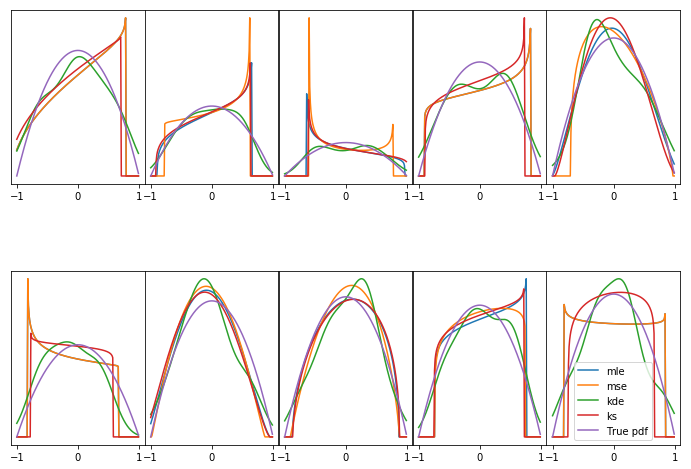

In [6]:
fit_beta(Y1,50,x,['mle','mse','kde','ks'])
#fit_beta(Y1,50,x,'kde')
#fit_beta(Y1,50,x,'mse')

In [22]:
N = [10,25,50]
n_iter = 250
n_samples = 10000

In [8]:
# simple quadratic cost function
# f1 = lambda x,y: -x*y + 0.2*x**2 
f1 = lambda x,y: -x*y + 5*x**2 + 2*x 

f3 = lambda x,y: 3*x**2 + 6*x*y**2 - 2*x**2*y - 7*x*y

f2 = lambda x,y: -x*y + 0.2*x**2

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [10]:
def minimise_dist(distribution,function,n_samples=10000):
    # minimises a cost function according to a given distribution
    samples = distribution.rvs(size=n_samples)
    
    # minimise the cost function
    res = minimize(function,0.0,args=(samples))
    return res.x

In [11]:
# concave function in x
f1_mean = lambda x,y: np.mean(f1(x,y),axis=0)
f2_mean = lambda x,y: np.mean(f2(x,y),axis=0)
f3_mean = lambda x,y: np.mean(f3(x,y),axis=0)

In [16]:
def minimise_methods(distribution,function,N,n_iter=500,n_samples=5000):
    results = np.zeros((4,n_iter,len(N)))
    for k in range(n_iter):
        for j in range(len(N)):
            # obtain the samples
            S = distribution.rvs(N[j])

            # maximise using SAA
            results[0,k,j]= minimize(function,0.0,args=(S)).x


            # fit a beta distribution using MLE
            beta_params = st.beta.fit(S)
            fitted = st.beta(beta_params[0],beta_params[1],
                            beta_params[2],beta_params[3])
            samples = fitted.rvs(size=n_samples)
            res = minimize(function,0.0,args=(samples))
            results[1,k,j] = res.x

            # fit distribution using kde
            fitted = st.gaussian_kde(S,bw_method='scott')
            samples = fitted.resample(size=n_samples)
            res = minimize(function,0.0,args=(np.reshape(samples,(-1))))
            results[2,k,j] = res.x
            """
            # fit distribution using maximum spacing estimation
            a,b,loc,scale = minimize(maximum_spacing,beta_params,args=(S),
                                        bounds=((0,None),(0,None),(None,None),
                                               (None,None))).x
            fitted_beta = st.beta(a=a,b=b,loc=loc,scale=scale)
            samples = fitted_beta.rvs(size=n_samples)
            res = minimize(function,0.0,args=(samples))
            results[3,k,j] = res.x

            # fit beta using MLE with fixed support
            a1, b1,loc1,scale1= st.beta.fit(S,floc=-1,fscale=2)
            fitted = st.beta(a = a1,b=b1,loc=-1,scale=2)
            samples = fitted.rvs(size=n_samples)
            res = minimize(function,0.0,args=(samples))
            results[4,k,j] = res.x
            """
            a,b,loc,scale = minimize(test_compute_kstest,beta_params,args=(S),
                                        bounds=((0,None),(0,None),(None,None),
                                               (None,None))).x
            fitted_beta = st.beta(a=a,b=b,loc=loc,scale=scale)
            samples = fitted_beta.rvs(size=n_samples)
            res = minimize(function,0.0,args=(samples))
            results[3,k,j] = res.x
    return results

In [13]:
def plot_result(results,plot_histogram=False,y_label='average expected cost'):
    #plt.figure(figsize=(10,5))
    if plot_histogram:
        for i in range(results.shape[0]):
            plt.hist(results[i,:,0],bins=30,normed=True,alpha=1.0/(i+1))
            plt.title("Distribution of x_star for N=25")
    else:
        mean=np.mean(results,axis=1)
        std=np.std(results,axis=1)
        width=0.05
        N = [10,25,50]
        #for i in range(results.shape[0]):
        for i in range(results.shape[-1]):
            plt.figure(figsize=(10,5))
        #sns.boxplot(x="no of samples", y="expected cost", hue="technique",
        #            data=results, palette="Set3")
            #for j in range(results.shape[0]):
            plt.boxplot(results[:,:,i].T)
            #plt.bar(np.arange(len(N))+width*i, mean[i]-min(mean[i]), 
            #        width,bottom=min(mean[i]),
            #       yerr=std[i])
            #plt.xticks(np.arange(len(N)) + width / 2, (N))
            #
            plt.xticks(np.arange(6)+1 + width / 2,
                       ['SAA','MLE','KDE','KS'])
            plt.ylabel('Expected cost')
            plt.title("Expected cost for %s" %str(N[i]))
            plt.show()
            #plt.plot(N,mean[i])
            #plt.errorbar(N, mean[i], yerr=std[i],capsize=5)
        #plt.xlabel('No of samples')
        #
        #plt.legend(['SAA','MLE','KDE','MSE','fixed support MSE','KS'])

## Results 2.1
These are the results for: <br>
            <center>$ 5x^2 -xy + 2x $</center>

Text(0.5,0,'y')

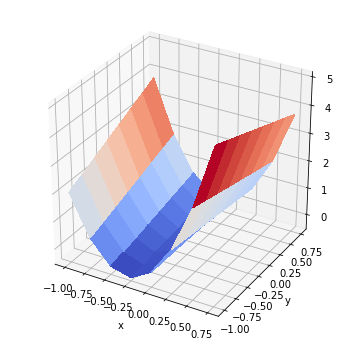

In [14]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
Z = f1(X,Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")

In [23]:
results1 = minimise_methods(Y1,f1_mean,N,n_iter)

In [24]:
def calculate_expected_cost(x_star_array,distribution,function,n_samples=10000):
    """
    we calculate the expected cost for a given x*, cost function and
    beta distribution using monte carlo
    """
    samples = distribution.rvs(n_samples)
    expected_cost = np.mean(function(np.reshape(x_star_array,(-1,1)),samples),axis=1)
    return np.reshape(expected_cost,x_star_array.shape)

In [25]:
expected_cost1 = calculate_expected_cost(results1,Y1,f1)

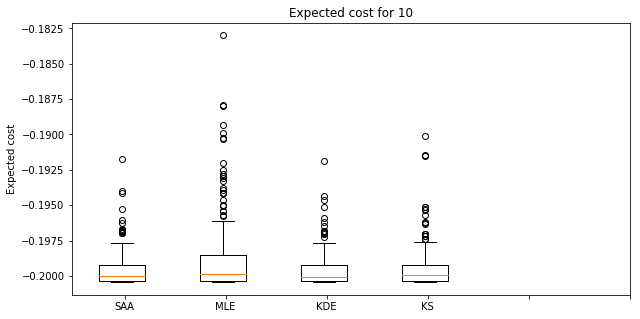

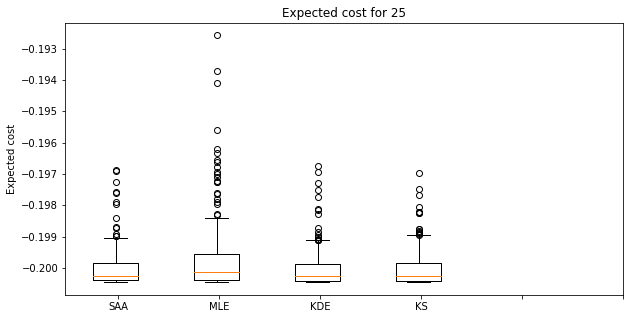

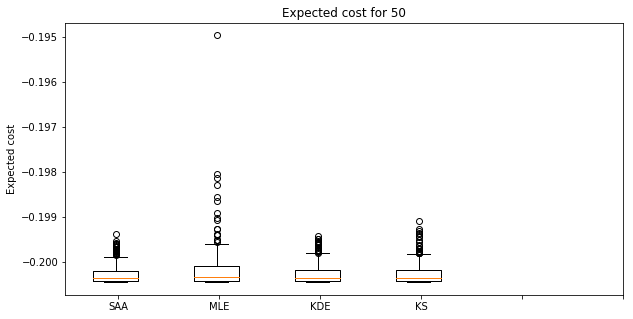

In [26]:
plot_result(expected_cost1)

In [27]:
results2 = minimise_methods(Y2,f1_mean,N,n_iter)

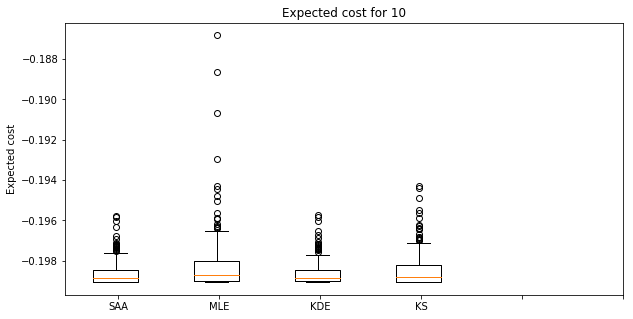

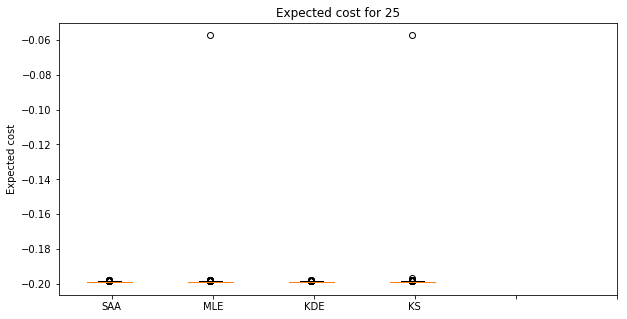

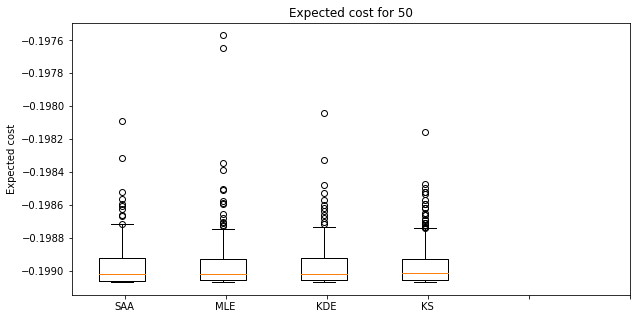

In [28]:
expected_cost2 = calculate_expected_cost(results2,Y2,f1)
plot_result(expected_cost2)

In [29]:
results3 = minimise_methods(Y3,f1_mean,N,n_iter)

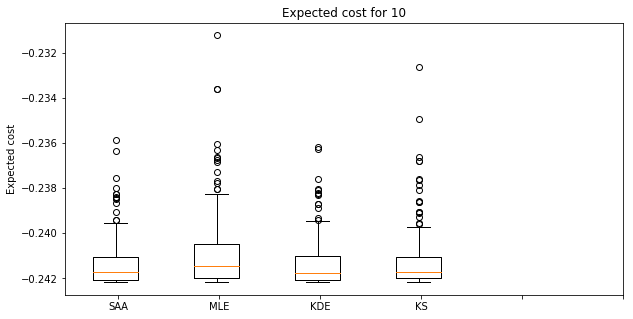

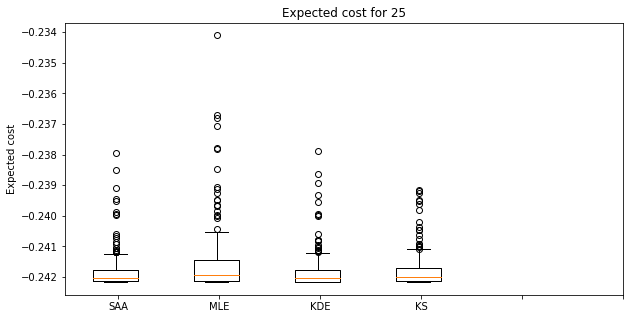

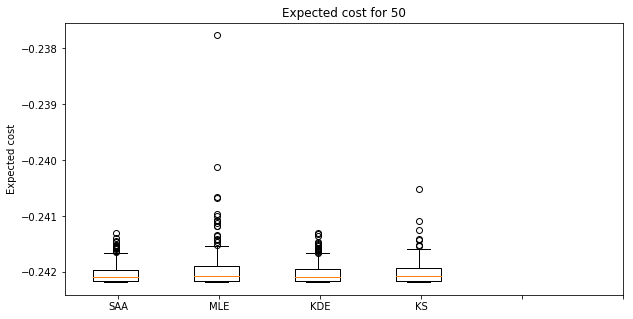

In [30]:
expected_cost3 = calculate_expected_cost(results3,Y3,f1)
plot_result(expected_cost3)

In [31]:
results4 = minimise_methods(Y4,f1_mean,N,n_iter)

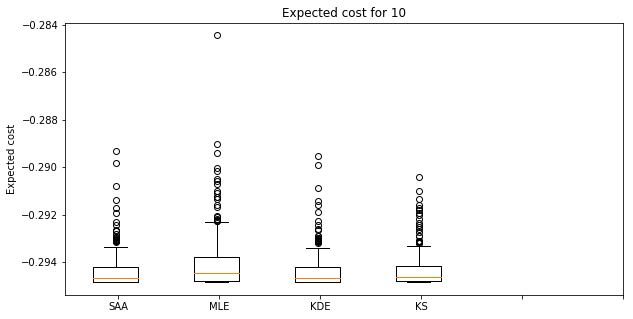

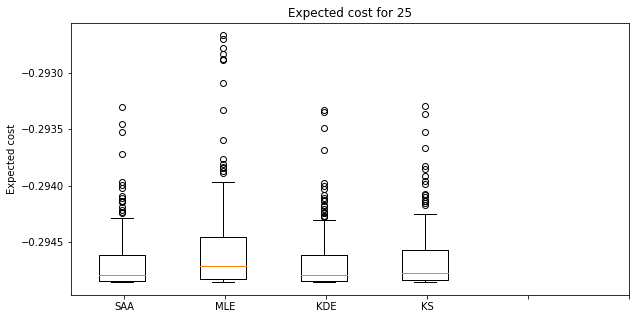

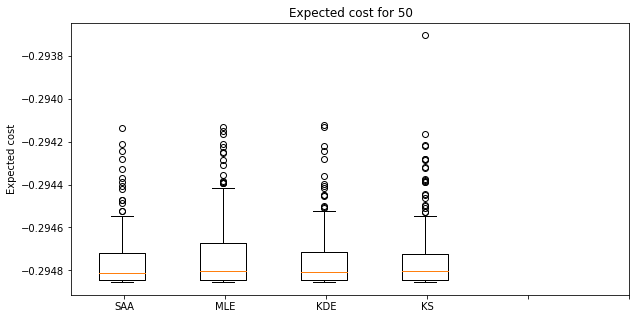

In [32]:
expected_cost4 = calculate_expected_cost(results4,Y4,f1)
plot_result(expected_cost4)

In [33]:
def plot_distribution_results(results,labels):
    width = 0.1  
    # no of distributions
    no_distribution = len(results)
    ind = np.arange(no_distribution)
    
    mean = np.mean(
        np.array([expected_cost1,expected_cost2,expected_cost3,expected_cost4]),axis=2)
    std = np.std(
        np.array([expected_cost1,expected_cost2,expected_cost3,expected_cost4]),axis=2)
    for i in range(std.shape[-1]):
        for j in range(std.shape[1]):
            plt.bar(ind+width*j, mean[:,j,i]+0.20, width,bottom=-0.20, label=labels[j],
                   yerr=std[:,j,i])
        plt.xticks(ind + width / 2, ('Y1', 'Y2', 'Y3', 'Y4'))
        plt.legend()
        plt.show()
        
"""
plt.ylabel('Scores')
plt.title('Scores by group and gender')

plt.xticks(ind + width / 2, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.legend(loc='best')
"""

"\nplt.ylabel('Scores')\nplt.title('Scores by group and gender')\n\nplt.xticks(ind + width / 2, ('G1', 'G2', 'G3', 'G4', 'G5'))\nplt.legend(loc='best')\n"

## Results 2.2
These are the results for: <br>
            <center>$0.2x^2 -xy $</center>

Text(0.5,0,'y')

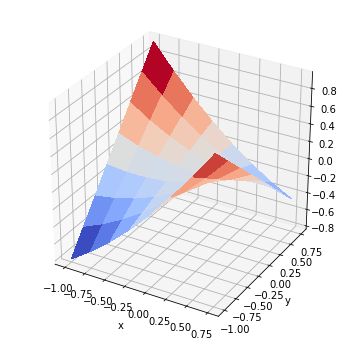

In [34]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
Z = f2(X,Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")

In [35]:
results1_f2 = minimise_methods(Y1,f2_mean,N,n_iter)

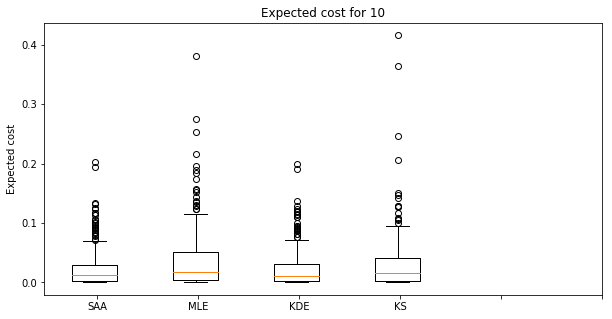

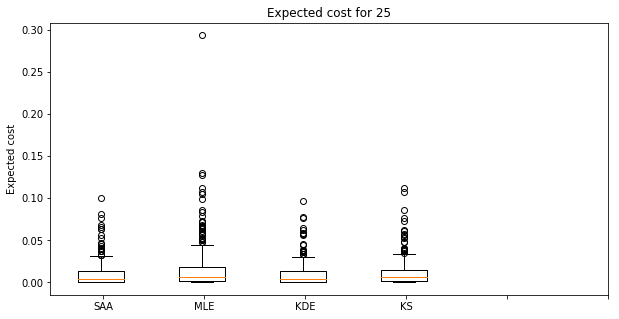

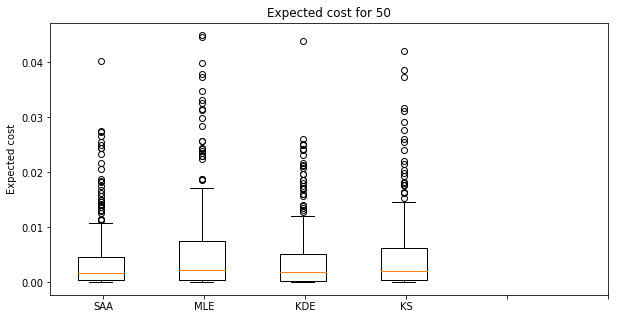

In [36]:
expected_cost1_f2 = calculate_expected_cost(results1_f2,Y1,f2)
plot_result(expected_cost1_f2)

In [37]:
results2_f2 = minimise_methods(Y2,f2_mean,N,n_iter)

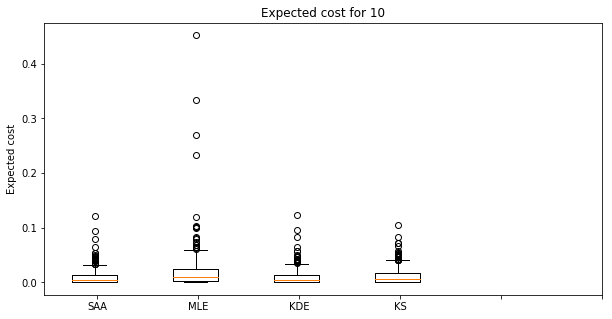

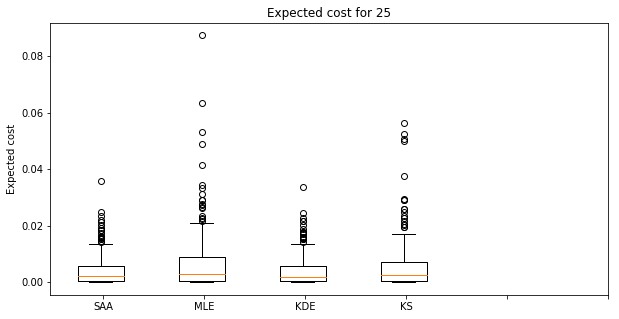

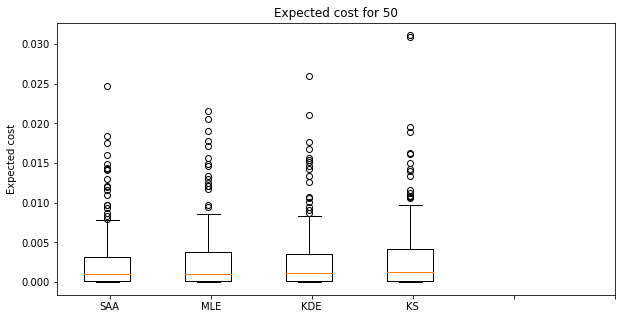

In [38]:
expected_cost2_f2 = calculate_expected_cost(results2_f2,Y2,f2)
plot_result(expected_cost2_f2)

In [39]:
results3_f2 = minimise_methods(Y3,f2_mean,N,n_iter)

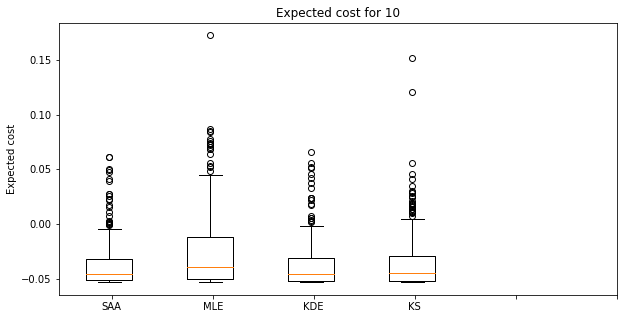

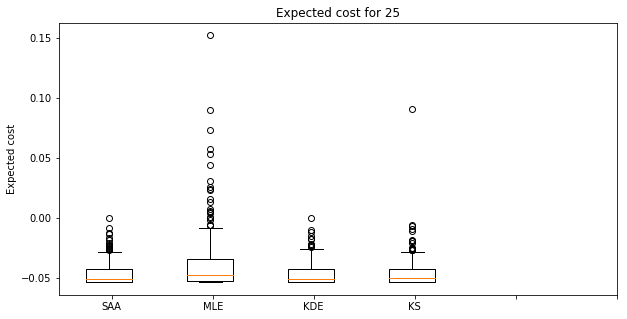

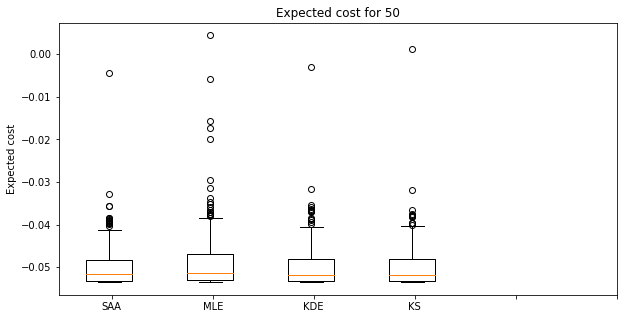

In [40]:
expected_cost3_f2 = calculate_expected_cost(results3_f2,Y3,f2)
plot_result(expected_cost3_f2)

In [41]:
results4_f2 = minimise_methods(Y4,f2_mean,N,n_iter)

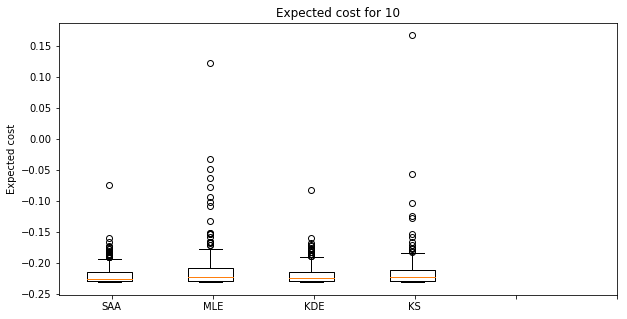

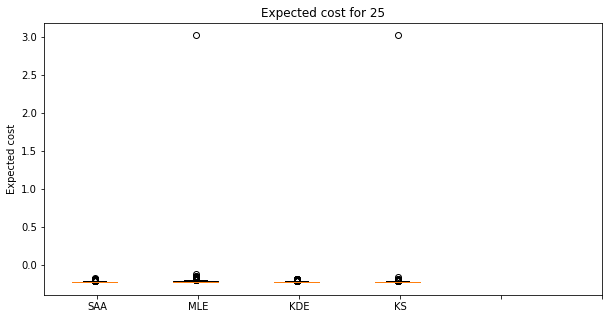

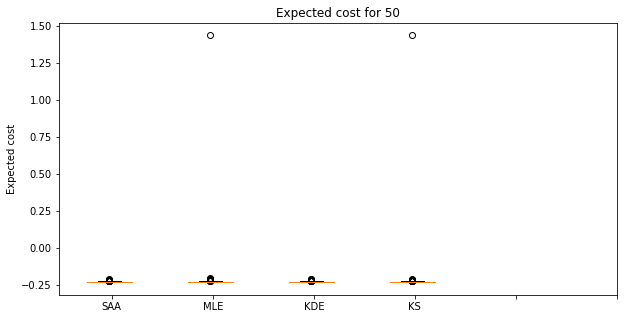

In [42]:
expected_cost4_f2 = calculate_expected_cost(results4_f2,Y4,f2)
plot_result(expected_cost4_f2)

## Results
These are the results for: <br>
            <center>$ 3x^2 + 6xy^2 - 2x^2y - 7xy $</center>

Text(0.5,0,'y')

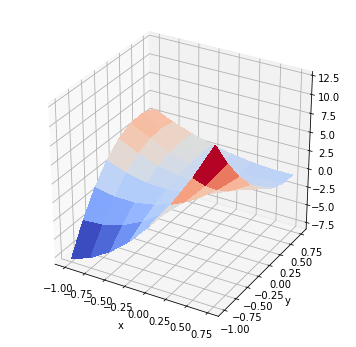

In [43]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
Z = f3(X,Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")

In [46]:
results1_f3 = minimise_methods(Y1,f3_mean,N,n_iter)

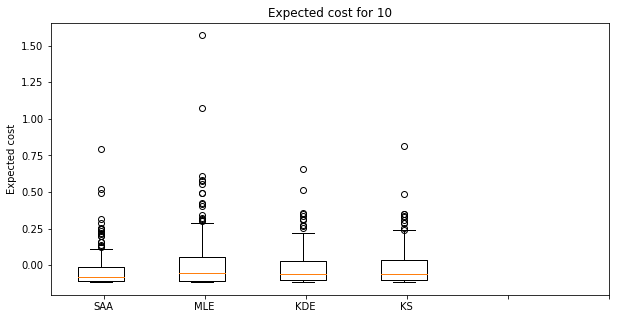

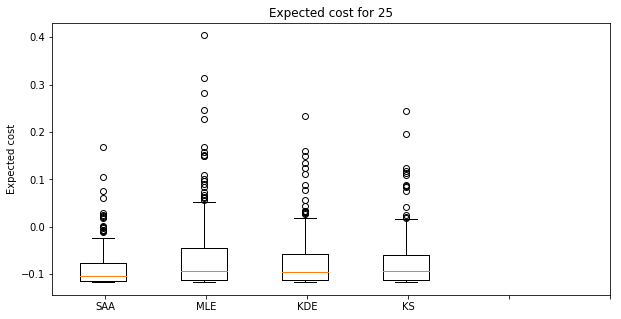

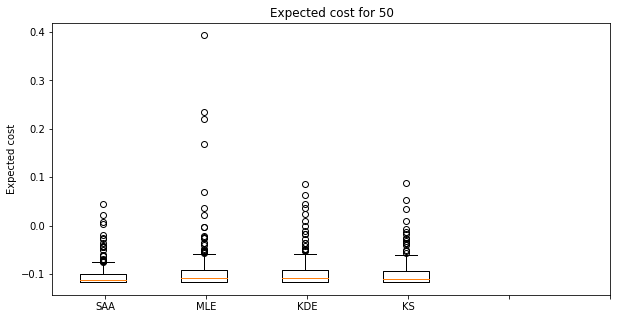

In [47]:
expected_cost1_f3 = calculate_expected_cost(results1_f3,Y1,f3)
plot_result(expected_cost1_f3)

In [48]:
results2_f3 = minimise_methods(Y2,f3_mean,N,n_iter)

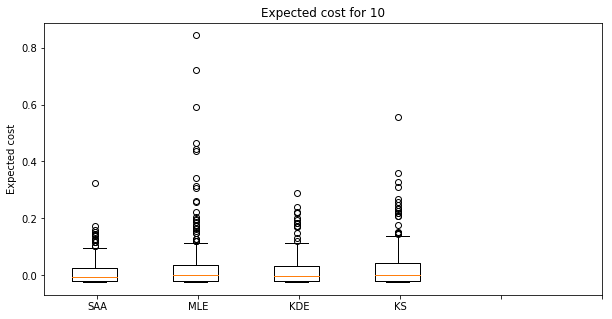

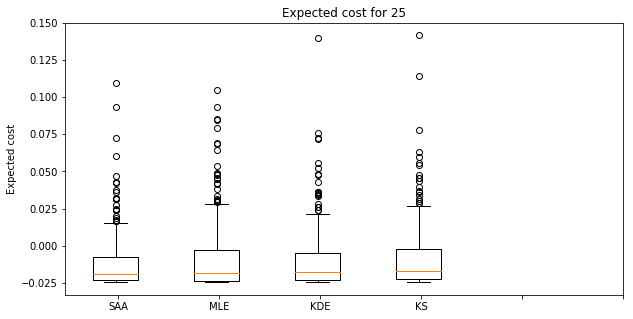

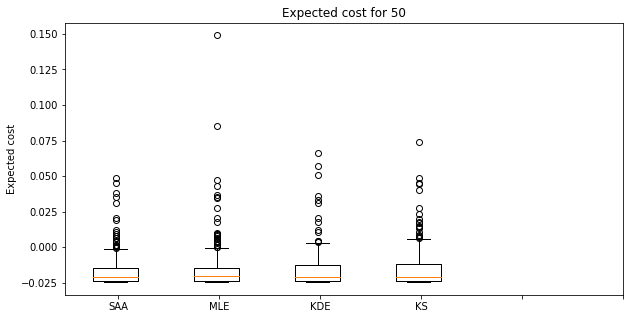

In [49]:
expected_cost2_f3 = calculate_expected_cost(results2_f3,Y2,f3)
plot_result(expected_cost2_f3)

In [50]:
results3_f3 = minimise_methods(Y3,f3_mean,N,n_iter)

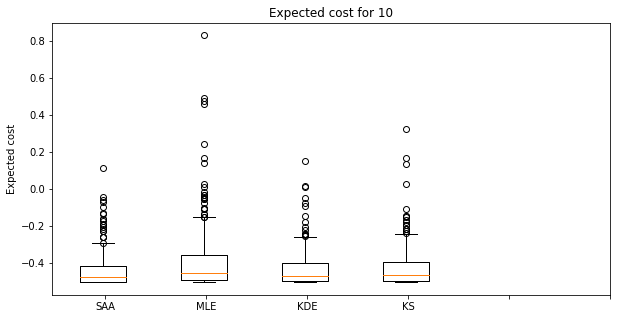

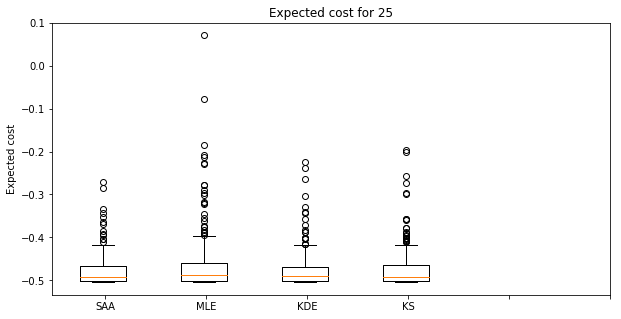

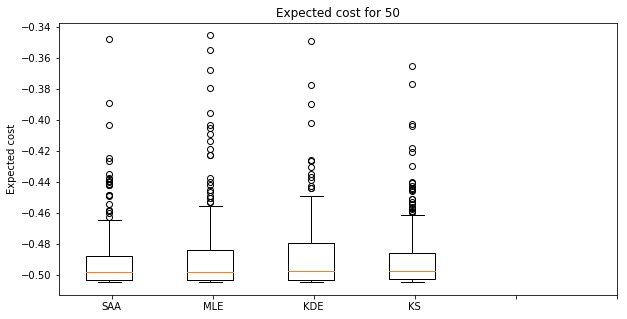

In [51]:
expected_cost3_f3 = calculate_expected_cost(results3_f3,Y3,f3)
plot_result(expected_cost3_f3)

In [52]:
results4_f3 = minimise_methods(Y4,f3_mean,N,n_iter)

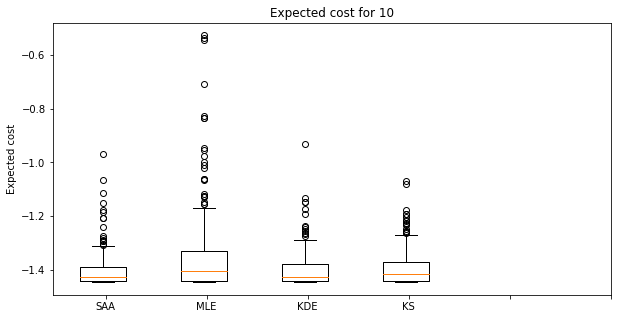

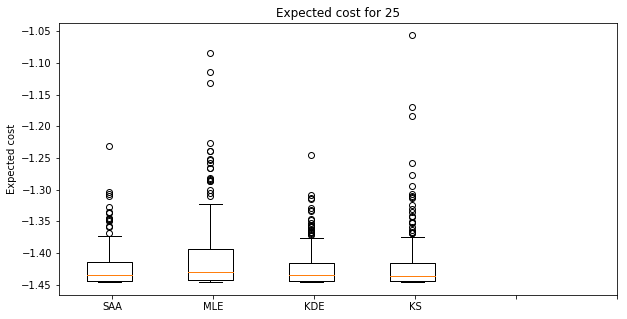

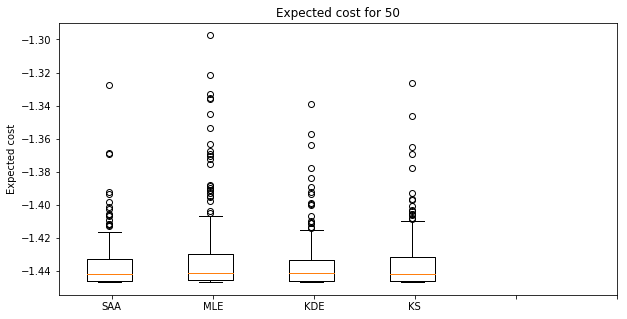

In [53]:
expected_cost4_f3 = calculate_expected_cost(results4_f3,Y4,f3)
plot_result(expected_cost4_f3)